In [1]:
pip install evaluate

In [2]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import evaluate
import json
import matplotlib.pyplot as plt
import os

In [3]:
# ============================================================
# 1. Load & clean dataset
# ============================================================

print("Loading dataset...")
ds = load_dataset("ailsntua/QEvasion")

# remove empty rows
ds = ds.filter(lambda x: bool(x["interview_question"]) and bool(x["interview_answer"]))

# map labels
clarity_labels = sorted(set(ds["train"]["clarity_label"]))
evasion_labels = sorted(set(ds["train"]["evasion_label"]))

clarity2id = {c: i for i, c in enumerate(clarity_labels)}
id2clarity = {i: c for c, i in clarity2id.items()}
evasion2id = {c: i for i, c in enumerate(evasion_labels)}
id2evasion = {i: c for c, i in evasion2id.items()}

print("Clarity labels:", clarity2id)
print("Evasion labels:", evasion2id)

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Clarity labels: {'Ambivalent': 0, 'Clear Non-Reply': 1, 'Clear Reply': 2}
Evasion labels: {'Claims ignorance': 0, 'Clarification': 1, 'Declining to answer': 2, 'Deflection': 3, 'Dodging': 4, 'Explicit': 5, 'General': 6, 'Implicit': 7, 'Partial/half-answer': 8}


In [4]:
# ============================================================
# 2. Tokenizer
# ============================================================

model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


def preprocess(batch):
    """Use HF's built-in text pair encoding (question, answer)."""

    enc = tokenizer(
        batch["interview_question"],
        batch["interview_answer"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

    enc["labels"] = [
        (
            clarity2id[c] if c in clarity2id else 0,
            evasion2id[e] if e in evasion2id else 0
        )
        for c, e in zip(batch["clarity_label"], batch["evasion_label"])
    ]

    return enc


print("Tokenizing dataset...")
encoded = ds.map(preprocess, batched=True)

# keep only model-required columns
encoded = encoded.remove_columns(
    [c for c in ds["train"].column_names if c not in ["labels"]]
)

encoded.set_format("torch")

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing dataset...


Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

In [5]:
# ============================================================
# 3. Multi-task model
# ============================================================

class MultiTaskDeberta(nn.Module):
    def __init__(self, base_model, num_clarity, num_evasion):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(base_model)
        hidden = self.encoder.config.hidden_size

        self.clarity_head = nn.Linear(hidden, num_clarity)
        self.evasion_head = nn.Linear(hidden, num_evasion)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        enc_out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls = enc_out.last_hidden_state[:, 0, :]

        logits_clarity = self.clarity_head(cls)
        logits_evasion = self.evasion_head(cls)

        loss = None
        if labels is not None:
            labels_clarity = labels[:, 0]
            labels_evasion = labels[:, 1]

            loss = (
                self.loss_fn(logits_clarity, labels_clarity) +
                self.loss_fn(logits_evasion, labels_evasion)
            ) / 2.0

        return {
            "loss": loss,
            "logits_clarity": logits_clarity,
            "logits_evasion": logits_evasion
        }


print("Initializing model...")
model = MultiTaskDeberta(
    base_model=model_name,
    num_clarity=len(clarity2id),
    num_evasion=len(evasion2id)
)

Initializing model...


In [6]:
# ============================================================
# 4. Metrics
# ============================================================

acc = evaluate.load("accuracy")


def compute_metrics(pred):
    logits_clarity = pred.predictions["logits_clarity"]
    logits_evasion = pred.predictions["logits_evasion"]

    preds_clarity = logits_clarity.argmax(axis=-1)
    preds_evasion = logits_evasion.argmax(axis=-1)

    labels = pred.label_ids
    labels_clarity = labels[:, 0]
    labels_evasion = labels[:, 1]

    return {
        "clarity_accuracy": acc.compute(predictions=preds_clarity, references=labels_clarity)["accuracy"],
        "evasion_accuracy": acc.compute(predictions=preds_evasion, references=labels_evasion)["accuracy"]
    }

In [7]:
# ============================================================
# 5. Trainer setup
# ============================================================

training_args = TrainingArguments(
    output_dir="./clarity_model",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    logging_steps=50,
    do_eval = True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded.get("validation", encoded["test"]),
    compute_metrics=compute_metrics
)

print("\nStarting training...\n")
trainer.train()

print("Saving model and trainer state...")
trainer.save_model("./clarity_model")
trainer.save_state()


Starting training...



Step,Training Loss
50,1.521400
100,1.432200
150,1.345500
200,1.439800
250,1.331800
300,1.397600
350,1.385100
400,1.326900
450,1.343200
500,1.429900


Saving model and trainer state...


In [8]:
# Force save trainer state (for plotting)
os.makedirs("./clarity_model", exist_ok=True)
with open("./clarity_model/trainer_state.json", "w") as f:
    json.dump(trainer.state.log_history, f)


Plotting training curves...



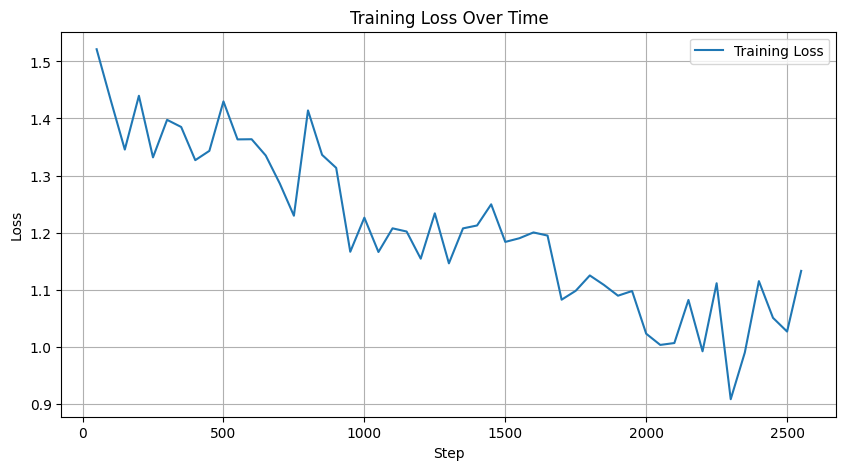

In [9]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import evaluate
import json
import matplotlib.pyplot as plt
import os

# ============================================================
# 6. Plot Training Loss and Evaluation Metrics
# ============================================================

print("\nPlotting training curves...\n")

state_file = "./clarity_model/trainer_state.json"

if os.path.exists(state_file):
    with open(state_file, "r") as f:
        state = json.load(f)

    if isinstance(state, list):
        logs = state
    else:
        logs = state["log_history"]

    steps, train_loss = [], []
    clarity_acc_vals, evasion_acc_vals = [], []

    for entry in logs:
        if "loss" in entry and "step" in entry:
            steps.append(entry["step"])
            train_loss.append(entry["loss"])
        if "eval_clarity_accuracy" in entry:
            clarity_acc_vals.append(entry["eval_clarity_accuracy"])
        if "eval_evasion_accuracy" in entry:
            evasion_acc_vals.append(entry["eval_evasion_accuracy"])

    # Training loss
    plt.figure(figsize=(10,5))
    plt.plot(steps, train_loss, label="Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Evaluation metrics
    if clarity_acc_vals or evasion_acc_vals:
        plt.figure(figsize=(10,5))
        if clarity_acc_vals:
            plt.plot(range(1, len(clarity_acc_vals)+1), clarity_acc_vals,
                     label="Clarity Accuracy")
        if evasion_acc_vals:
            plt.plot(range(1, len(evasion_acc_vals)+1), evasion_acc_vals,
                     label="Evasion Accuracy")
        plt.xlabel("Evaluation Epoch")
        plt.ylabel("Accuracy")
        plt.title("Evaluation Metrics Over Epochs")
        plt.grid(True)
        plt.legend()
        plt.show()

else:
    print("trainer_state.json not found. Run training first.")


In [10]:
# ============================================================
# 7. Inference wrapper
# ============================================================

def predict(question, answer):
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    encoded = tokenizer(
        question,
        answer,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )

    inputs = {k: v.to(device) for k, v in encoded.items()}

    with torch.no_grad():
        out = model(**inputs)

    clarity_id = out["logits_clarity"].argmax(dim=-1).item()
    evasion_id = out["logits_evasion"].argmax(dim=-1).item()

    return id2clarity[clarity_id], id2evasion[evasion_id]

In [11]:
# ============================================================
# 8. Examples
# ============================================================

examples = [
    ("Why did you veto the bill?",
     "Because the timing was not appropriate."),

    ("Can you explain why the health budget was reduced?",
     "We are looking into multiple ways of improving efficiency."),

    ("Do you take responsibility for the outcome?",
     "Our team has been working very hard and we are committed to improvement."),

    ("Why was the water infrastructure project delayed?",
     "We are currently reviewing contractor proposals to ensure compliance."),

    ("Can you explain why the education grant was cut this quarter?",
     "Several departments are undergoing restructuring to optimize future funding."),

    ("Did your office approve the new zoning changes?",
     "Urban development is a collaborative process, and many stakeholders are involved."),

    ("Why haven't the environmental reports been released yet?",
     "We want to ensure that all findings are thoroughly verified before publication."),

    ("Is the transportation department responsible for the recent safety lapses?",
     "Safety is a shared responsibility and we're evaluating all contributing factors."),

    ("Why did you choose not to attend the committee hearing?",
     "Scheduling conflicts required my attention elsewhere, but my team was present."),

    ("Are you planning to revise the energy policy this year?",
     "We are exploring many promising avenues and will have more to share soon."),

    ("Why were the housing subsidies paused?",
     "We're analyzing long-term impacts to ensure sustainability."),

    ("Did the agency conduct the internal audit as required?",
     "Audits are ongoing, and we'll release findings once the review is complete."),

    ("What led to the recent increase in administrative fees?",
     "The agency is evaluating cost structures to improve service delivery.")
]

print("\nExample Predictions:\n")
for q, a in examples:
    c, e = predict(q, a)
    print(f"Q: {q}\nA: {a}\n→ Clarity: {c} | Evasion: {e}\n")


Example Predictions:

Q: Why did you veto the bill?
A: Because the timing was not appropriate.
→ Clarity: Ambivalent | Evasion: Explicit

Q: Can you explain why the health budget was reduced?
A: We are looking into multiple ways of improving efficiency.
→ Clarity: Ambivalent | Evasion: Dodging

Q: Do you take responsibility for the outcome?
A: Our team has been working very hard and we are committed to improvement.
→ Clarity: Ambivalent | Evasion: Dodging

Q: Why was the water infrastructure project delayed?
A: We are currently reviewing contractor proposals to ensure compliance.
→ Clarity: Ambivalent | Evasion: Dodging

Q: Can you explain why the education grant was cut this quarter?
A: Several departments are undergoing restructuring to optimize future funding.
→ Clarity: Ambivalent | Evasion: Dodging

Q: Did your office approve the new zoning changes?
A: Urban development is a collaborative process, and many stakeholders are involved.
→ Clarity: Ambivalent | Evasion: Dodging

Q: Wh